# Load Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import random
import math
import seaborn as sns
from sklearn.model_selection import train_test_split

# Create Model
- Combine the three CSVs
- Split into training and test data

In [2]:
# Combine the three csvs
first_df = pd.read_csv('./dataset/users_final_games1.csv')
second_df = pd.read_csv('./dataset/users_final_games2.csv')
third_df = pd.read_csv('./dataset/users_final_games3.csv', header=None)

column_names = [
    "ID",
    "PlayerID",
    "GameID",
    "GameName",
    "GameGenre",
    "RunID",
    "RunTime",
    "CategoryType",
    "PlayerCountry",
    "PlayerPronouns",
    "PlayerSignupDate"
]

first_df.columns = column_names
second_df.columns = column_names
third_df.columns = column_names

df = pd.concat([first_df, second_df, third_df], ignore_index=True)

# Clean the data = Only include players who played more than one game 
player_game_counts = df.groupby('PlayerID')['GameID'].nunique()
valid_players = player_game_counts[player_game_counts > 1].index
df_clean = df[df['PlayerID'].isin(valid_players)]


In [3]:
train_rows = []
test_rows = []

for player_id, player_df in df_clean.groupby('PlayerID'):
    games = player_df['GameName'].unique()
    if len(games) < 5:
        continue  # skip players with too few games

    train_games, test_games = train_test_split(
        games, test_size=0.2, random_state=42
    )

    train_rows.append(player_df[player_df['GameName'].isin(train_games)])
    test_rows.append(player_df[player_df['GameName'].isin(test_games)])

train_df = pd.concat(train_rows)
test_df = pd.concat(test_rows)


In [4]:
# collaborative filtering matrix ON ALL DATA 
# basically if a player played a game, put a 1. Otherwise, put a 0. Use for collaborative filtering
# built on training data only 
player_game_matrix_all = df_clean.pivot_table(index='PlayerID', columns='GameName',
                                          values='RunID', aggfunc='count', fill_value=0)
player_game_matrix_all = (player_game_matrix_all > 0).astype(int)

# get the genre, category, and country
game_genre_all = df_clean.drop_duplicates('GameName').set_index('GameName')['GameGenre'].fillna('Unknown')
game_category_all = df_clean.drop_duplicates('GameName').set_index('GameName')['CategoryType'].fillna('Unknown')
player_country_all = df_clean.drop_duplicates('PlayerID').set_index('PlayerID')['PlayerCountry']


In [5]:
# collaborative filtering matrix ON TRAINING DATA 
player_game_matrix = train_df.pivot_table(index='PlayerID', columns='GameName',
                                          values='RunID', aggfunc='count', fill_value=0)
player_game_matrix = (player_game_matrix > 0).astype(int)

# get the genre, category, and country
game_genre = train_df.drop_duplicates('GameName').set_index('GameName')['GameGenre'].fillna('Unknown')
game_category = train_df.drop_duplicates('GameName').set_index('GameName')['CategoryType'].fillna('Unknown')
player_country = train_df.drop_duplicates('PlayerID').set_index('PlayerID')['PlayerCountry']


In [6]:
# Recommender
def recommend_hybrid(player_game_matrix, game_genre, game_category, player_country,
                     user_games, user_country=None, country_boost=True, alpha=0.6, beta=0.2, gamma=0.2, top_n=5):
    # Collaborative = builds vector of current user's games and then calculates cosine similarity with all other players
    user_vector = pd.Series(0, index=player_game_matrix.columns)
    for game in user_games:
        if game in user_vector.index:
            user_vector[game] = 1

    similarities = cosine_similarity([user_vector], player_game_matrix.values)[0]

    # Country boost = if player is in the same country, they get a 10% boost (Optional) 
    if country_boost:
        if user_country:
            boost_indices = [i for i, pid in enumerate(player_game_matrix.index) 
                             if player_country.get(pid, None) == user_country]
            similarities[boost_indices] *= 1.1

    # find the top 30 players who are most similar to the current player 
    top_player_indices = similarities.argsort()[::-1][:30]
    # for each game, how many of the 30 most similar players played it?
    top_players = player_game_matrix.iloc[top_player_indices]
    collab_scores = top_players.sum()

    # Genre = Determine what genre the player likes and sets it to 1 
    genre_preferences = set(game_genre.get(g) for g in user_games if g in game_genre.index)
    genre_scores = pd.Series(0, index=player_game_matrix.columns)
    for game in genre_scores.index:
        if game_genre.get(game, None) in genre_preferences:
            genre_scores[game] = 1

    # Category = Determine what category the player likes and sets it to 1 
    category_preferences = set(game_category.get(g) for g in user_games if g in game_category.index)
    category_scores = pd.Series(0, index=player_game_matrix.columns)
    for game in category_scores.index:
        if game_category.get(game, None) in category_preferences:
            category_scores[game] = 1

    # Combine scores
    combined_scores = alpha * collab_scores + beta * genre_scores + gamma * category_scores
    combined_scores = combined_scores.drop(labels=user_games, errors='ignore')

    recommended_games = combined_scores.sort_values(ascending=False).head(top_n)

    return recommended_games.index.tolist()

# Evaluate Model

In [7]:
# this evaluation method took all of the games a user played, hid it, and tested if the model would recommend the hidden game
def evaluate_hybrid(df, player_game_matrix, game_genre, game_category, player_country, country_boost=True,
                    sample_size=50, top_n=5, alpha=0.7, beta=0.2, gamma=0.1):
    
    print("Evaluating Hybrid Recommender...")

    sampled_players = df['PlayerID'].drop_duplicates().sample(sample_size, random_state=42)
    recall_at_k = []
    precision_at_k = []
    mrr_scores = []
    ndcg_scores = []

    for player_id in tqdm(sampled_players, desc="Evaluating players"):
        # For each player, get each unique game they played and their country 
        player_games = df[df['PlayerID'] == player_id]['GameName'].unique().tolist()
        country = df[df['PlayerID'] == player_id]['PlayerCountry'].iloc[0]

        if len(player_games) < 2:
            continue

        # pick a random game that they've played = hide it 
        true_game = random.choice(player_games)
        input_games = [g for g in player_games if g != true_game]

        if not input_games:
            continue

        # recommend 5 games for them 
        recs = recommend_hybrid(
            player_game_matrix, game_genre, game_category, player_country,
            input_games, user_country=country, country_boost=country_boost,
            alpha=alpha, beta=beta, gamma=gamma, top_n=top_n
        )

        # see if the hidden game is in the recommendations. If it is, add it to recall and precision arrays 
        hit = int(true_game in recs)
        recall_at_k.append(hit)
        precision_at_k.append(hit / top_n)

        # calculate MRR score
        if hit:
            rank = recs.index(true_game) + 1
            mrr_scores.append(1.0 / rank)
        else:
            mrr_scores.append(0)

        # calculate NDCG score
        dcg = 0
        for i, rec_game in enumerate(recs):
            if rec_game == true_game:
                dcg = 1 / math.log2(i + 2)  # rank position is i+1, log base 2
                break
        idcg = 1  # ideal DCG is 1 because true game would be ranked first
        ndcg_scores.append(dcg / idcg)

    # Create DataFrame
    results_df = pd.DataFrame({
        'Recall@5': recall_at_k,
        'Precision@5': precision_at_k,
        'MRR': mrr_scores,
        'NDCG@5': ndcg_scores
    })

    # Count hits and misses
    hits = sum(recall_at_k)
    misses = len(recall_at_k) - hits

    # Plot hit vs miss
    plt.figure(figsize=(6, 5))
    sns.barplot(x=["Hit (True Game Recommended)", "Miss"], y=[hits, misses])
    plt.title("Recommendation Accuracy (Recall@5)")
    plt.ylabel("Number of Players")
    plt.xlabel("")
    plt.tight_layout()
    plt.show()

    
    return results_df

In [25]:
# this evaluation is done on a sample of the test set 
def evaluate_on_test_set(test_df, player_game_matrix, game_genre, game_category, player_country, sample_size,
                         alpha=0.6, beta=0.2, gamma=0.2, top_n=5):
    
    recall_at_k = []
    precision_at_k = []
    mrr_scores = []
    ndcg_scores = []

    # take a sample of sample_size players from the test set 
    sampled_test_players = test_df['PlayerID'].drop_duplicates().sample(sample_size, random_state=42)
    test_players = test_df[test_df['PlayerID'].isin(sampled_test_players)]

    for player_id in tqdm(test_players['PlayerID'].unique(), desc="Evaluating players"):
        if player_id not in player_game_matrix.index:
            continue  # skip if not in training set

        # Get training input games
        input_games = player_game_matrix.columns[player_game_matrix.loc[player_id] > 0].tolist()
        if len(input_games) == 0:
            continue

        # Get true games from the test set
        true_games = test_df[test_df['PlayerID'] == player_id]['GameName'].unique().tolist()
        if not true_games:
            continue

        country = player_country.get(player_id, None)

        recs = recommend_hybrid(
            player_game_matrix, game_genre, game_category, player_country,
            input_games, user_country=country,
            alpha=alpha, beta=beta, gamma=gamma, top_n=top_n
        )

        hits = [g for g in true_games if g in recs]
        recall = len(hits) / len(true_games)
        precision = len(hits) / top_n

        recall_at_k.append(recall)
        precision_at_k.append(precision)

        # MRR and NDCG: use the *first* hit for simplicity
        mrr = 0
        ndcg = 0
        for i, rec_game in enumerate(recs):
            if rec_game in true_games:
                mrr = 1.0 / (i + 1)
                ndcg = 1 / math.log2(i + 2)
                break
        mrr_scores.append(mrr)
        ndcg_scores.append(ndcg)

    results_df = pd.DataFrame({
        'Recall@5': recall_at_k,
        'Precision@5': precision_at_k,
        'MRR': mrr_scores,
        'NDCG@5': ndcg_scores
    })

    # Count hits and misses
    hits = sum(recall_at_k)
    misses = len(recall_at_k) - hits

    # Plot hit vs miss
    plt.figure(figsize=(6, 5))
    sns.barplot(x=["Hit (True Game Recommended)", "Miss"], y=[hits, misses])
    plt.title("Recommendation Accuracy (Recall@5)")
    plt.ylabel("Number of Players")
    plt.xlabel("")
    plt.tight_layout()
    plt.show()

    return results_df

# Test on Test Set


Evaluating players: 100%|█████████████████████| 500/500 [03:05<00:00,  2.70it/s]


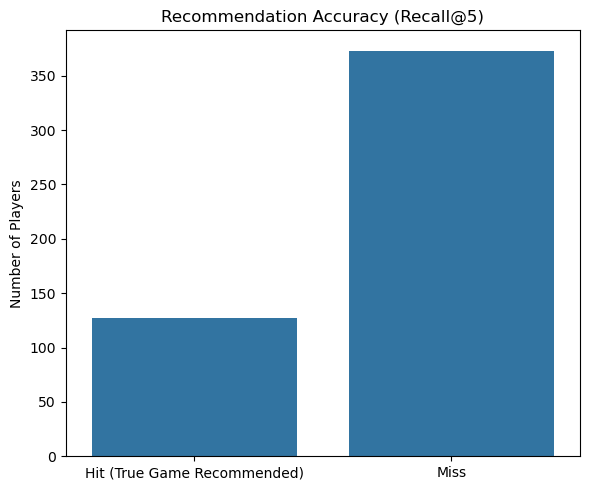

### Test Set Evaluation ###
Recall@5: 0.25372078406455484
Precision@5: 0.1288
MRR: 0.3879333333333333
NDCG@5: 0.41728689596464
Recommended Games: ['Super Mario 64 Category Extensions', 'SM64 Sapphire', 'Minecraft: Java Edition', 'Portal', 'Super Mario Odyssey']


In [24]:
# Set fixed weights
# Experiment and do ablation study of just a few weight changes?
alpha = 0.7
beta = 0.1
gamma = 0.2

results = evaluate_on_test_set(
    test_df, player_game_matrix, game_genre, game_category, player_country,
    alpha=alpha, beta=beta, gamma=gamma, top_n=5
)

print("### Test Set Evaluation ###")
print("Recall@5:", results['Recall@5'].mean())
print("Precision@5:", results['Precision@5'].mean())
print("MRR:", results['MRR'].mean())
print("NDCG@5:", results['NDCG@5'].mean())

# Example of player who played Celeste and Super Mario 64
user_games = ['Celeste', 'Super Mario 64']
recommendations = recommend_hybrid(
    player_game_matrix, game_genre, game_category, player_country,
    user_games,
    user_country='United States',
    alpha=alpha,
    beta=beta,
    gamma=gamma,
    top_n=5
)

print("Recommended Games:", recommendations)

# Test with one hidden game and is trained on all data


Evaluating Hybrid Recommender...


Evaluating players: 100%|███████████████████████| 50/50 [01:08<00:00,  1.38s/it]


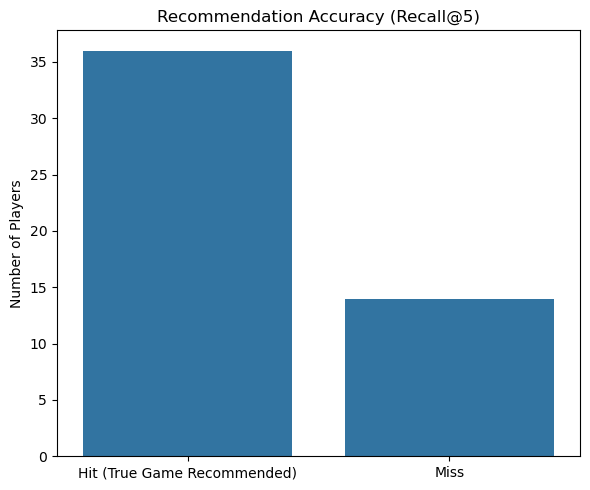


 ### Evaluation Metrics ###
Average Recall@5: 0.72
Average Precision@5: 0.14400000000000002
Average MRR: 0.4953333333333333
Average NDCG@5: 0.5513869913284415
Recommended Games: ['Super Mario 64 Category Extensions', 'SM64 Sapphire', 'Minecraft: Java Edition', 'Portal', 'Super Mario Odyssey']


In [10]:
alpha = 0.7
beta = 0.1
gamma = 0.2

# Evaluate the model with these fixed weights
evaluation_results = evaluate_hybrid(
    df_clean, 
    player_game_matrix_all, 
    game_genre_all, 
    game_category_all, 
    player_country_all,
    sample_size=50,
    top_n=5,
    alpha=alpha,
    beta=beta,
    gamma=gamma
)

print("\n ### Evaluation Metrics ###")
print("Average Recall@5:", evaluation_results['Recall@5'].mean())
print("Average Precision@5:", evaluation_results['Precision@5'].mean())
print("Average MRR:", evaluation_results['MRR'].mean())
print("Average NDCG@5:", evaluation_results['NDCG@5'].mean())


# Example of player who played Celeste and Super Mario 64
user_games = ['Celeste', 'Super Mario 64']
recommendations = recommend_hybrid(
    player_game_matrix, game_genre, game_category, player_country,
    user_games,
    user_country='United States',
    alpha=alpha,
    beta=beta,
    gamma=gamma,
    top_n=5
)

print("Recommended Games:", recommendations)

# Ablation Study on All Data Recommender
- Try out different weights

Evaluating players: 100%|███████████████████████| 50/50 [00:19<00:00,  2.58it/s]


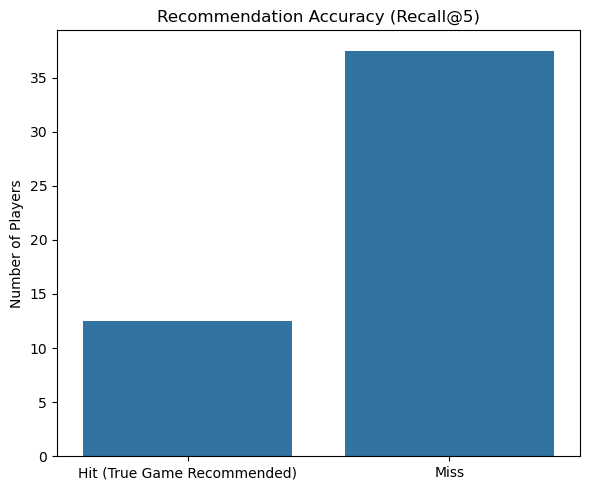

Evaluating players: 100%|███████████████████████| 50/50 [00:19<00:00,  2.63it/s]


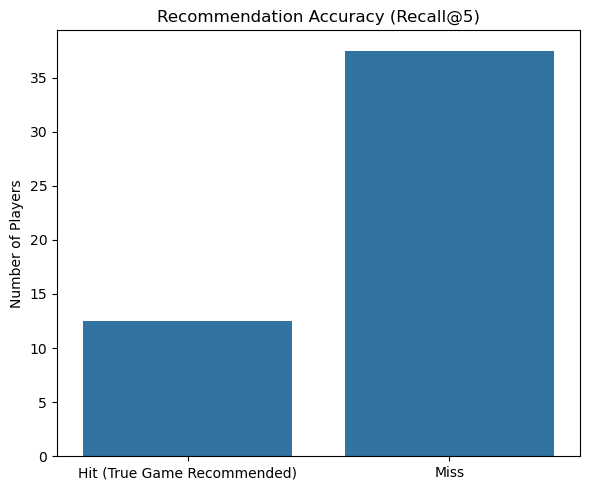

Evaluating players: 100%|███████████████████████| 50/50 [00:19<00:00,  2.56it/s]


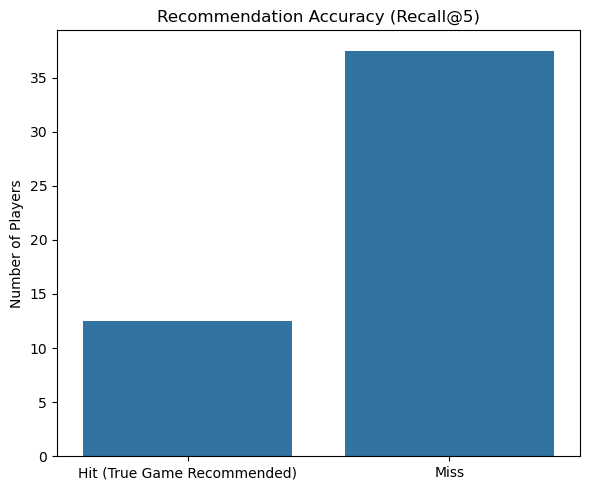

Evaluating players: 100%|███████████████████████| 50/50 [00:19<00:00,  2.58it/s]


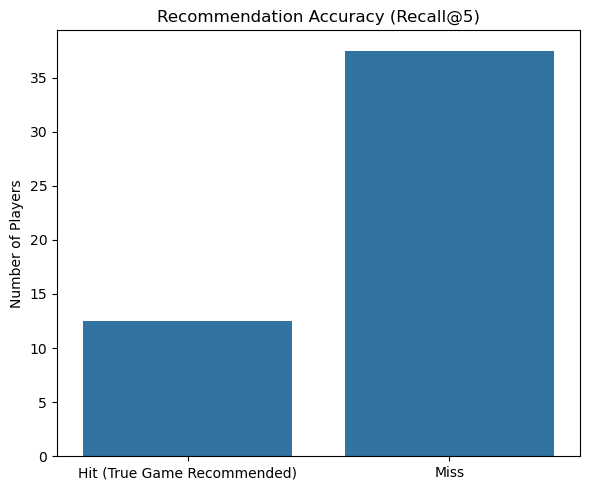

Evaluating players: 100%|███████████████████████| 50/50 [00:19<00:00,  2.56it/s]


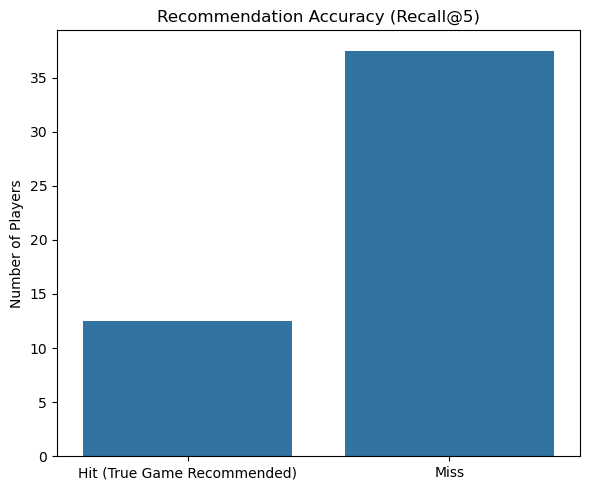

Evaluating players: 100%|███████████████████████| 50/50 [00:19<00:00,  2.58it/s]


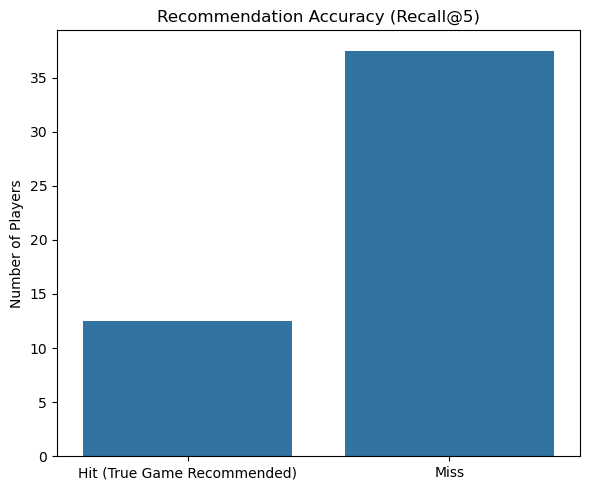

Evaluating players: 100%|███████████████████████| 50/50 [00:19<00:00,  2.59it/s]


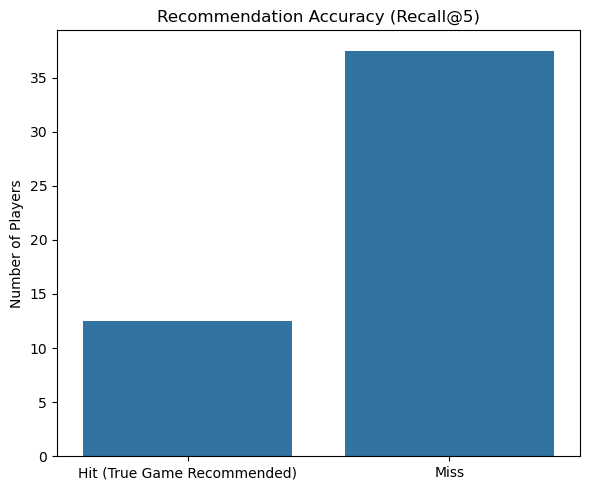


### Best Weights per Metric ###
RECALL: 0.2502 at weights alpha=0.50, beta=0.01, gamma=0.49
PRECISION: 0.1160 at weights alpha=0.50, beta=0.01, gamma=0.49
MRR: 0.4023 at weights alpha=0.50, beta=0.01, gamma=0.49
NDCG: 0.4268 at weights alpha=0.50, beta=0.01, gamma=0.49


In [26]:
alpha_vals = [0.5, 0.7, 0.9]
beta_vals = [0.01, 0.1, 0.2]

best_scores = {
    "recall": 0,
    "precision": 0,
    "mrr": 0,
    "ndcg": 0
}

best_weights = {
    "recall": None,
    "precision": None,
    "mrr": None,
    "ndcg": None
}

for alpha in alpha_vals:
    for beta in beta_vals:
        gamma = 1.0 - alpha - beta
        if gamma < 0:
            continue  # Skip invalid combinations

        evaluation_results = evaluate_on_test_set(
            test_df, player_game_matrix, game_genre, game_category, player_country,
            sample_size=50,
            alpha=alpha, beta=beta, gamma=gamma, top_n=5
        )

        recall = evaluation_results['Recall@5'].mean()
        precision = evaluation_results['Precision@5'].mean()
        mrr = evaluation_results['MRR'].mean()
        ndcg = evaluation_results['NDCG@5'].mean()

        if recall > best_scores["recall"]:
            best_scores["recall"] = recall
            best_weights["recall"] = (alpha, beta, gamma)

        if precision > best_scores["precision"]:
            best_scores["precision"] = precision
            best_weights["precision"] = (alpha, beta, gamma)

        if mrr > best_scores["mrr"]:
            best_scores["mrr"] = mrr
            best_weights["mrr"] = (alpha, beta, gamma)

        if ndcg > best_scores["ndcg"]:
            best_scores["ndcg"] = ndcg
            best_weights["ndcg"] = (alpha, beta, gamma)

# Print summary
print("\n### Best Weights per Metric ###")
for metric in best_scores:
    print(f"{metric.upper()}: {best_scores[metric]:.4f} at weights alpha={best_weights[metric][0]:.2f}, "
          f"beta={best_weights[metric][1]:.2f}, gamma={best_weights[metric][2]:.2f}")


# Try without country boost

In [28]:
# Set fixed weights
# Experiment and do ablation study of just a few weight changes?
alpha = 0.5
beta = 0.01
gamma = 0.49

# Evaluate the model with these fixed weights
evaluation_results = evaluate_on_test_set(
            test_df, player_game_matrix, game_genre, game_category, player_country,
            sample_size=50,country_boost=False,
            alpha=alpha, beta=beta, gamma=gamma, top_n=5
        )

print("\n ### Evaluation Metrics ###")
print("Average Recall@5:", evaluation_results['Recall@5'].mean())
print("Average Precision@5:", evaluation_results['Precision@5'].mean())
print("Average MRR:", evaluation_results['MRR'].mean())
print("Average NDCG@5:", evaluation_results['NDCG@5'].mean())


# Example of player who played Celeste and Super Mario 64
user_games = ['Celeste', 'Super Mario 64']
recommendations = recommend_hybrid(
    player_game_matrix_all, game_genre_all, game_category_all, player_country_all,
    user_games,
    alpha=alpha,
    beta=beta,
    gamma=gamma,
    top_n=5
)

print("Recommended Games:", recommendations)

TypeError: evaluate_on_test_set() got an unexpected keyword argument 'country_boost'